In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
from scipy import linalg
from sklearn.model_selection import GridSearchCV

sns.set_style("whitegrid")

In [9]:
n_samples = 500
np.random.seed(0)
C = np.array([[0.0, -0.1], [1.7, 0.4]])
component_1 = np.dot(np.random.randn(n_samples, 2), C)  # general
component_2 = 0.7 * np.random.randn(n_samples, 2) + np.array([-4, 1])  # spherical

X = np.concatenate([component_1, component_2])

In [16]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


def gmm_aic_score(estimator, X):
    return -estimator.aic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search_bic = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search_bic.fit(X)
grid_search_aic = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_aic_score
)
grid_search_aic.fit(X)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_aic_score at 0x147d3efc0>)

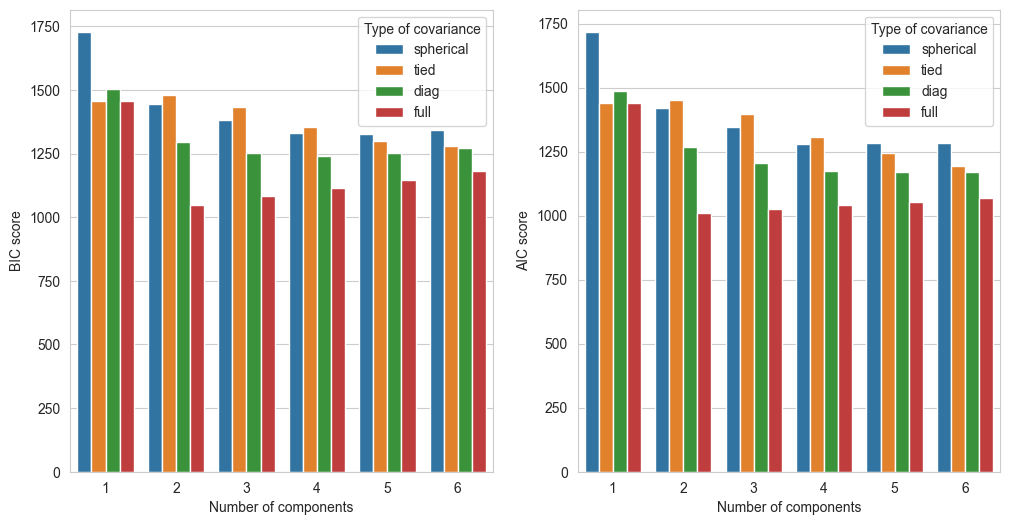

In [20]:
df_bic = pd.DataFrame(grid_search_bic.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df_bic["mean_test_score"] = -df_bic["mean_test_score"]
df_bic = df_bic.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df_bic.sort_values(by="BIC score").head()

df_aic = pd.DataFrame(grid_search_aic.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df_aic["mean_test_score"] = -df_aic["mean_test_score"]
df_aic = df_aic.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "AIC score",
    }
)
df_aic.sort_values(by="AIC score").head()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.barplot(
    data=df_bic,
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
    ax=ax[0],
)
sns.barplot(
    data=df_aic,
    x="Number of components",
    y="AIC score",
    hue="Type of covariance",
    ax=ax[1],
)
plt.show()

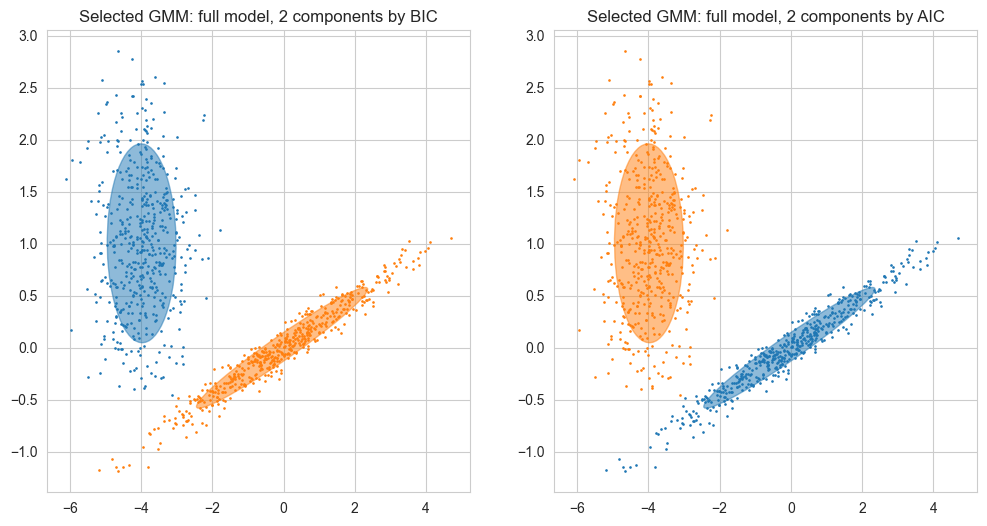

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

color_iter = sns.color_palette("tab10", 2)[::-1]
Y_ = grid_search_bic.predict(X)
for i, (mean, cov, color) in enumerate(
    zip(
        grid_search_bic.best_estimator_.means_,
        grid_search_bic.best_estimator_.covariances_,
        color_iter,
    )
):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    ax[0].scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
    ellipse.set_clip_box(fig.bbox)
    ellipse.set_alpha(0.5)
    ax[0].add_artist(ellipse)
ax[0].set_title(
    f"Selected GMM: {grid_search_bic.best_params_['covariance_type']} model, "
    f"{grid_search_bic.best_params_['n_components']} components "
    "by BIC"
)

color_iter = sns.color_palette("tab10", 2)[::-1]
Y_ = grid_search_aic.predict(X)
for i, (mean, cov, color) in enumerate(
    zip(
        grid_search_aic.best_estimator_.means_,
        grid_search_aic.best_estimator_.covariances_,
        color_iter,
    )
):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    ax[1].scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    ellipse = Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
    ellipse.set_clip_box(fig.bbox)
    ellipse.set_alpha(0.5)
    ax[1].add_artist(ellipse)
ax[1].set_title(
    f"Selected GMM: {grid_search_aic.best_params_['covariance_type']} model, "
    f"{grid_search_aic.best_params_['n_components']} components "
    "by AIC"
)

plt.show()